# Performance tests: Case 1

Flow: 
Source -(sourceout)-> Sink

The driving commodity is 'sourceout' with a demand equation of 1000*t

In [2]:
import json
import re
import subprocess
import os
import sqlite3 as lite
import copy
import glob
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import d3ploy.tester as tester
import d3ploy.plotter as plotter
import collections

# Delete previously generated files
direc = os.listdir('./')
hit_list = glob.glob('*.sqlite') + glob.glob('*.xml') + glob.glob('*.png') + glob.glob('*.csv') + glob.glob('*.txt')
for file in hit_list:
    os.remove(file)

ENV = dict(os.environ)
ENV['PYTHONPATH'] = ".:" + ENV.get('PYTHONPATH', '')

calc_methods = ["ma", "arma", "arch", "poly", "exp_smoothing", "holt_winters", "fft"]

demand_eq = "1000*t"

control = """
<control>
    <duration>20</duration>
    <startmonth>1</startmonth>
    <startyear>2000</startyear>
</control>"""

archetypes = """
<archetypes>
        <spec>
            <lib>cycamore</lib>
            <name>Source</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Sink</name>
        </spec>
        <spec>
            <lib>agents</lib>
            <name>NullRegion</name>
        </spec>
        <spec>
            <lib>agents</lib>
            <name>NullInst</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>DeployInst</name>
        </spec>
        <spec>
            <lib>d3ploy.timeseries_inst</lib>
            <name>TimeSeriesInst</name>
        </spec>
    </archetypes>
"""

source = """
<facility>
    <name>source</name>
    <config>
        <Source>
            <outcommod>sourceout</outcommod>
            <outrecipe>sourceoutrecipe</outrecipe>
            <throughput>3000</throughput>
        </Source>
    </config>
</facility>
"""

sink = """
<facility>
        <name>sink</name>
        <config>
            <Sink>
                <in_commods>
                    <val>sourceout</val>
                </in_commods>
                <max_inv_size>1e8</max_inv_size>
            </Sink>
        </config>
    </facility>
"""

region = {}

for calc_method in calc_methods:
    region[calc_method] = """
    <region>
        <config>
            <NullRegion>
            </NullRegion>
        </config>

        <institution>
          <config>
            <NullInst/>
          </config>
          <initialfacilitylist>
            <entry>
              <number>1</number>
              <prototype>sink</prototype>
            </entry>              
          </initialfacilitylist>
          <name>sink_source_facilities</name>
        </institution>

        <institution>
            <config>
                <TimeSeriesInst>
                    <calc_method>%s</calc_method>
                    <commodities>
                        <val>sourceout_source_3000</val>
                    </commodities>
                    <driving_commod>sourceout</driving_commod>
                    <demand_std_dev>0</demand_std_dev>
                    <demand_eq>%s</demand_eq>
                    <record>1</record>
                    <steps>1</steps>
                </TimeSeriesInst>
            </config>
            <name>source_inst</name>
            </institution>

        <name>SingleRegion</name>
    </region>
    """%(calc_method,demand_eq)

recipe = """
 <recipe>
   <name>sourceoutrecipe</name>
   <basis>mass</basis>
   <nuclide> <id>U235</id> <comp>0.711</comp> </nuclide>
   <nuclide> <id>U238</id> <comp>99.289</comp> </nuclide>
 </recipe>
 """

metric_dict = {}
for calc_method in calc_methods:

    input_file = 'case1_'+ calc_method +'.xml'
    output_file = 'case1_'+ calc_method +'.sqlite'
    name = 'case1_'+ calc_method +'_sourceout'

    with open(input_file, 'w') as f:
        f.write('<simulation>\n')
        f.write(control + archetypes)
        f.write(source + sink)
        f.write(region[calc_method])
        f.write(recipe)
        f.write('</simulation>')

    s = subprocess.check_output(['cyclus', '-o', output_file, input_file],
                            universal_newlines=True, env=ENV)

    all_dict_fuel = {} 
    all_dict_fuel = tester.supply_demand_dict_driving(output_file,demand_eq, 'sourceout')
    plotter.plot_demand_supply(all_dict_fuel, 'sourceout', name, True)

    metric_dict = tester.metrics(all_dict_fuel,metric_dict,calc_method,'sourceout',True)
    
    df = pd.DataFrame(metric_dict)
    df.to_csv('case1_output.csv')

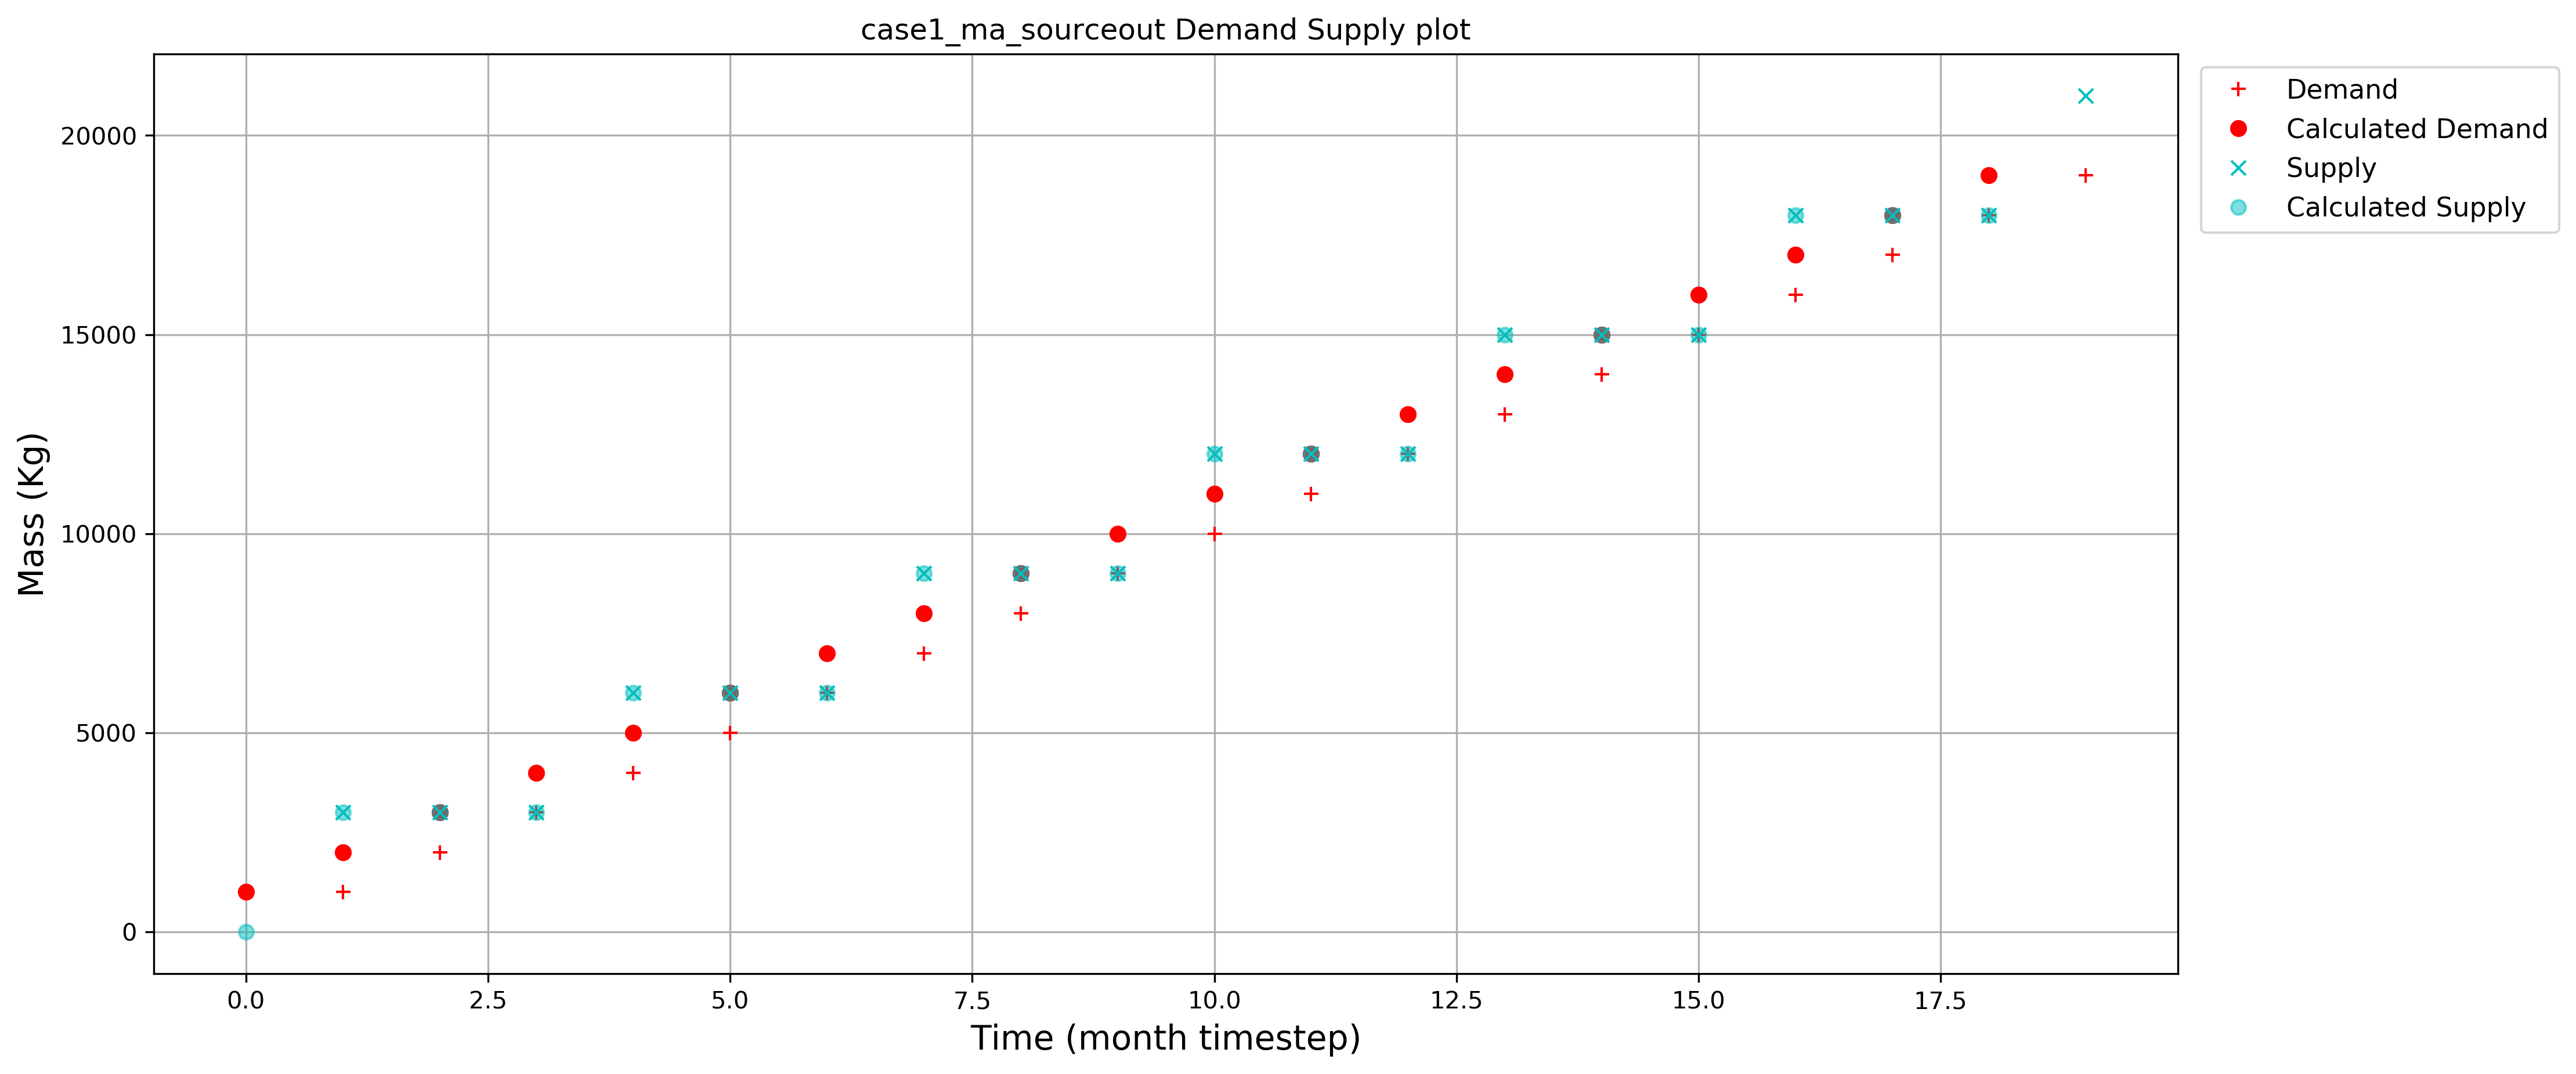

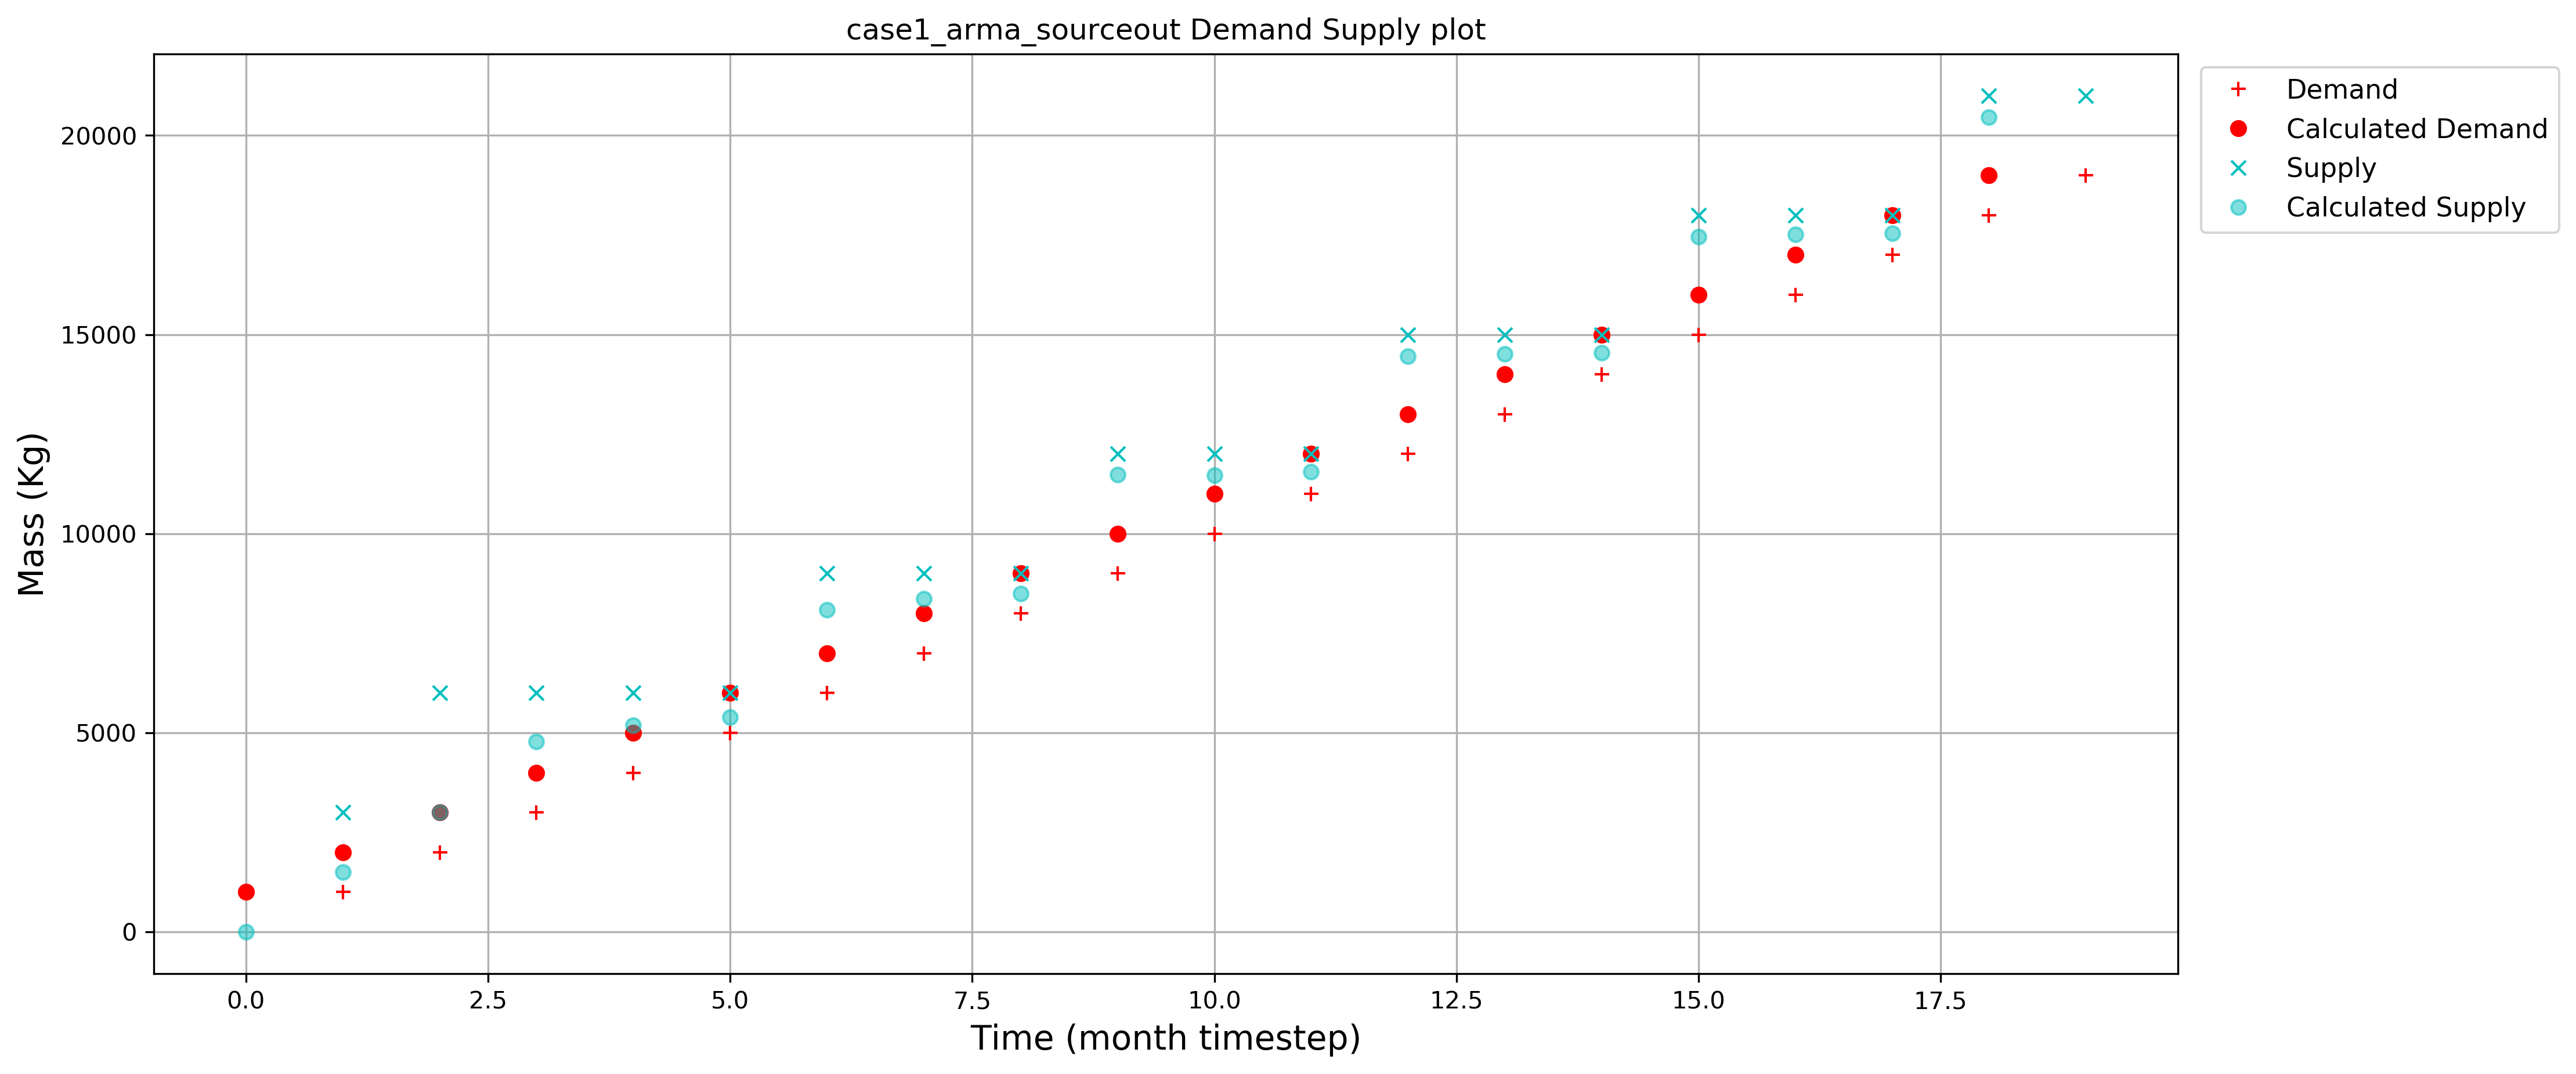

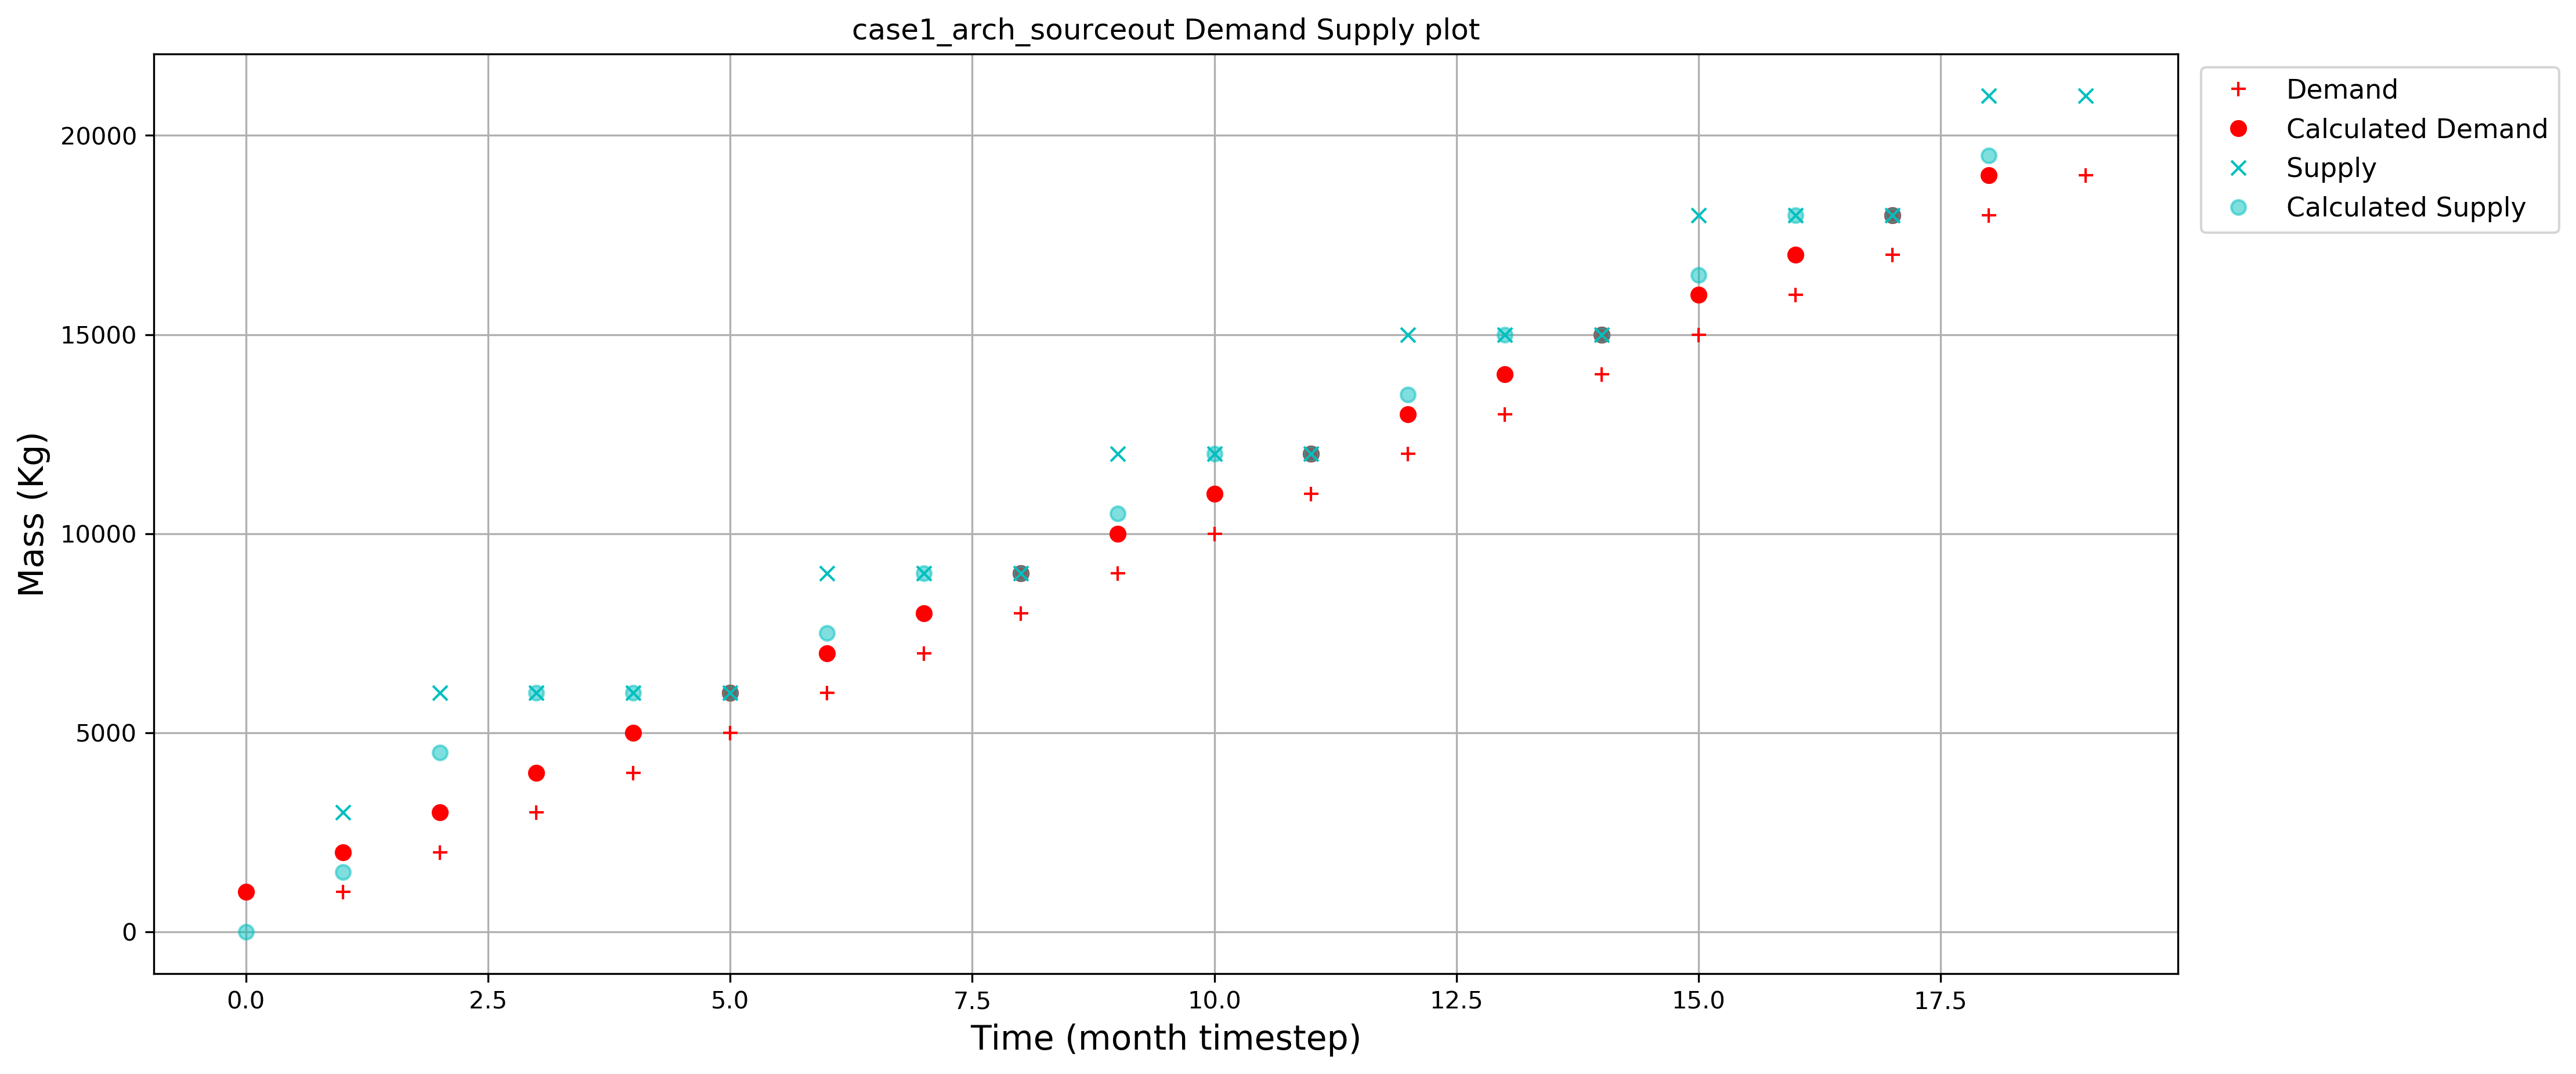

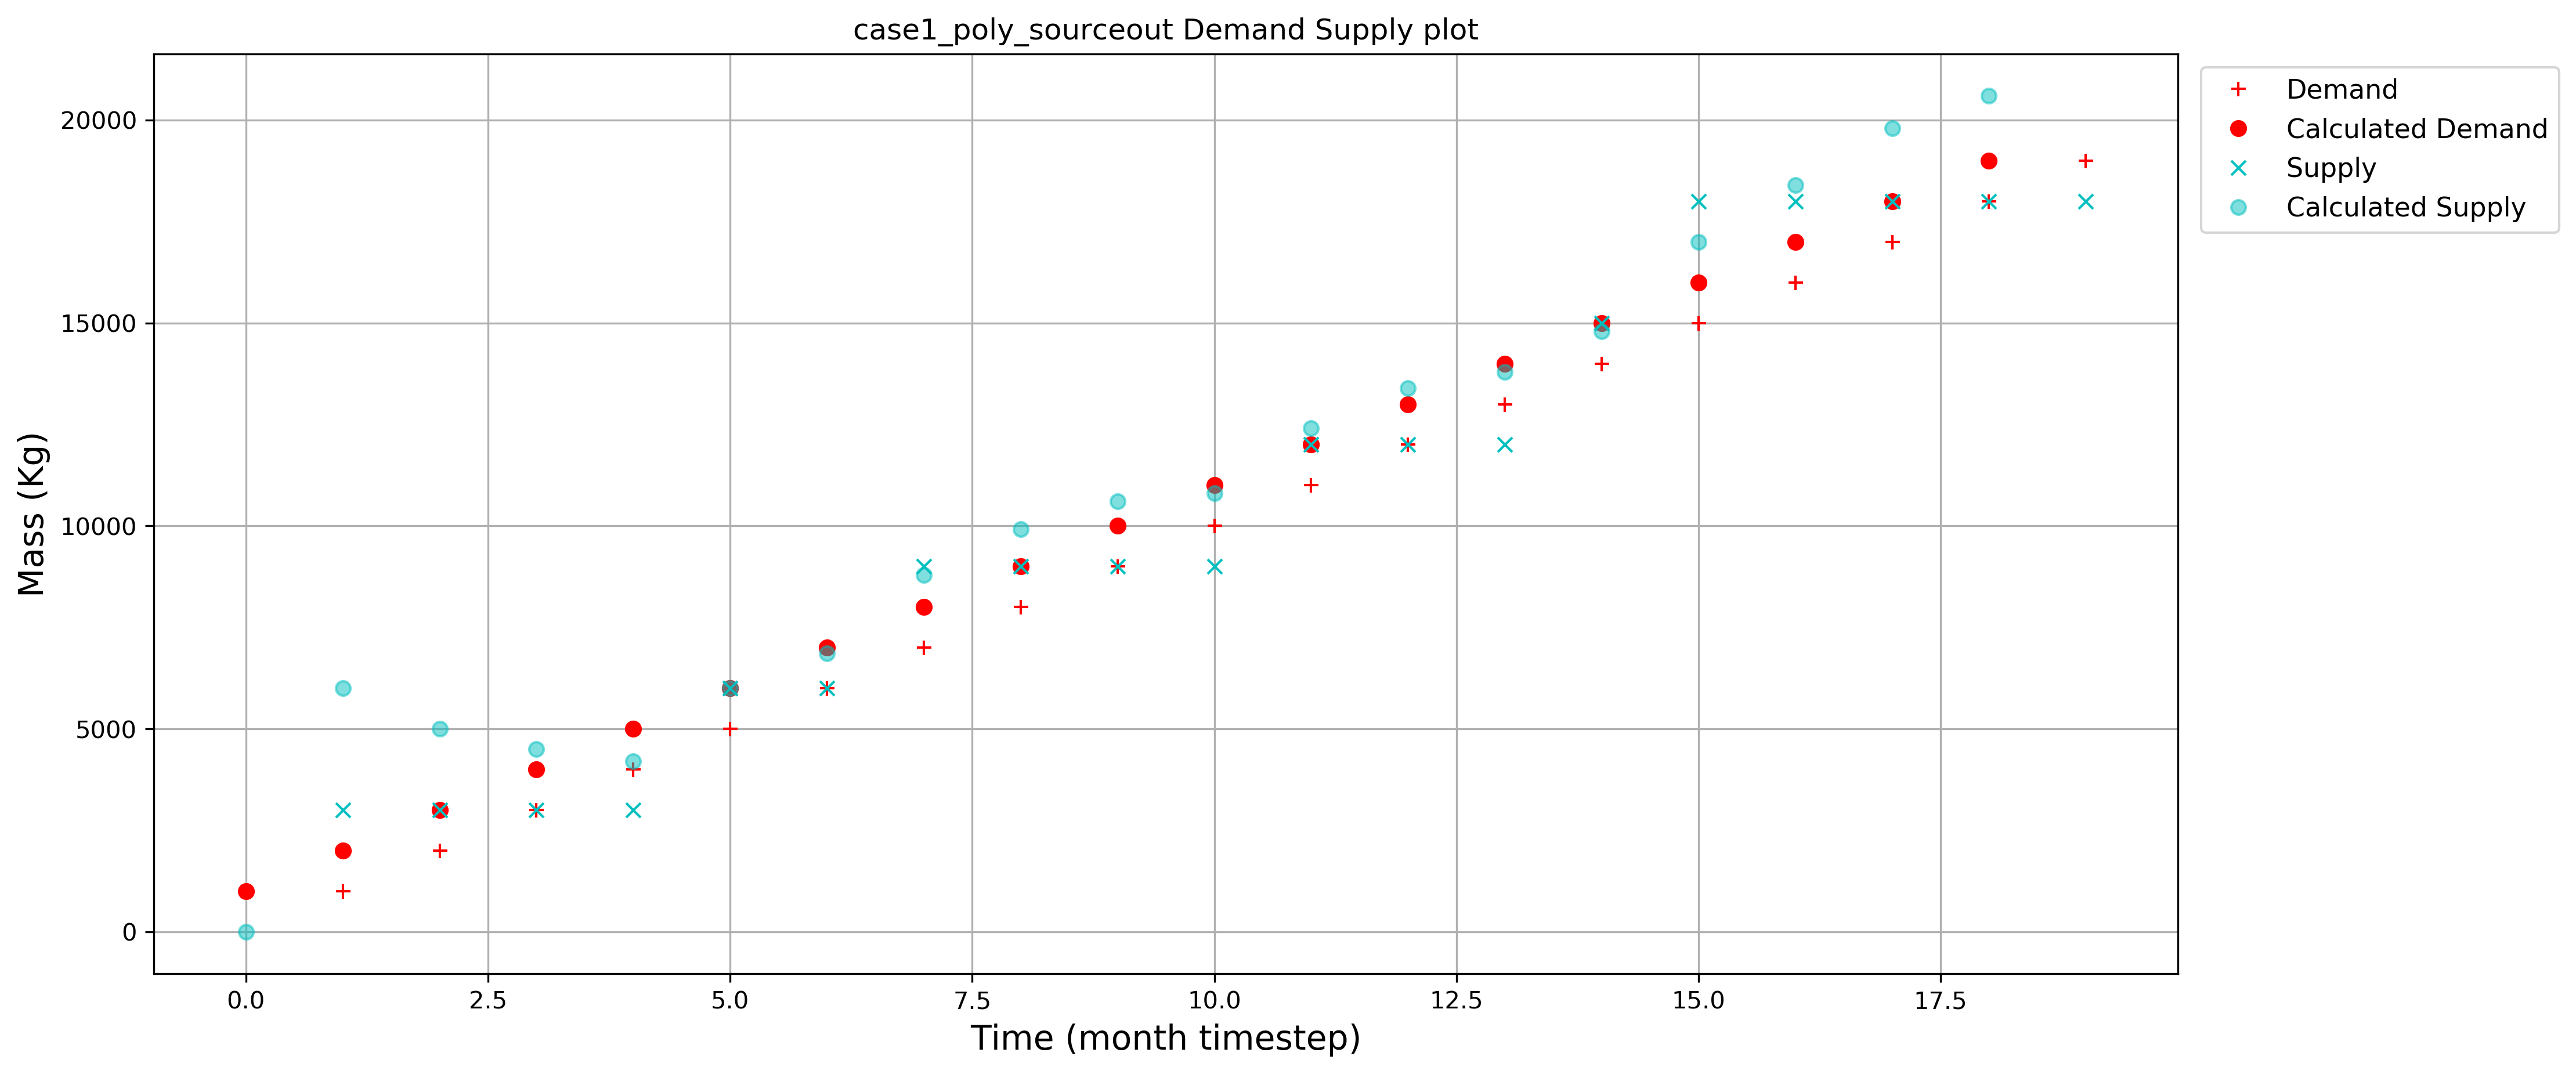

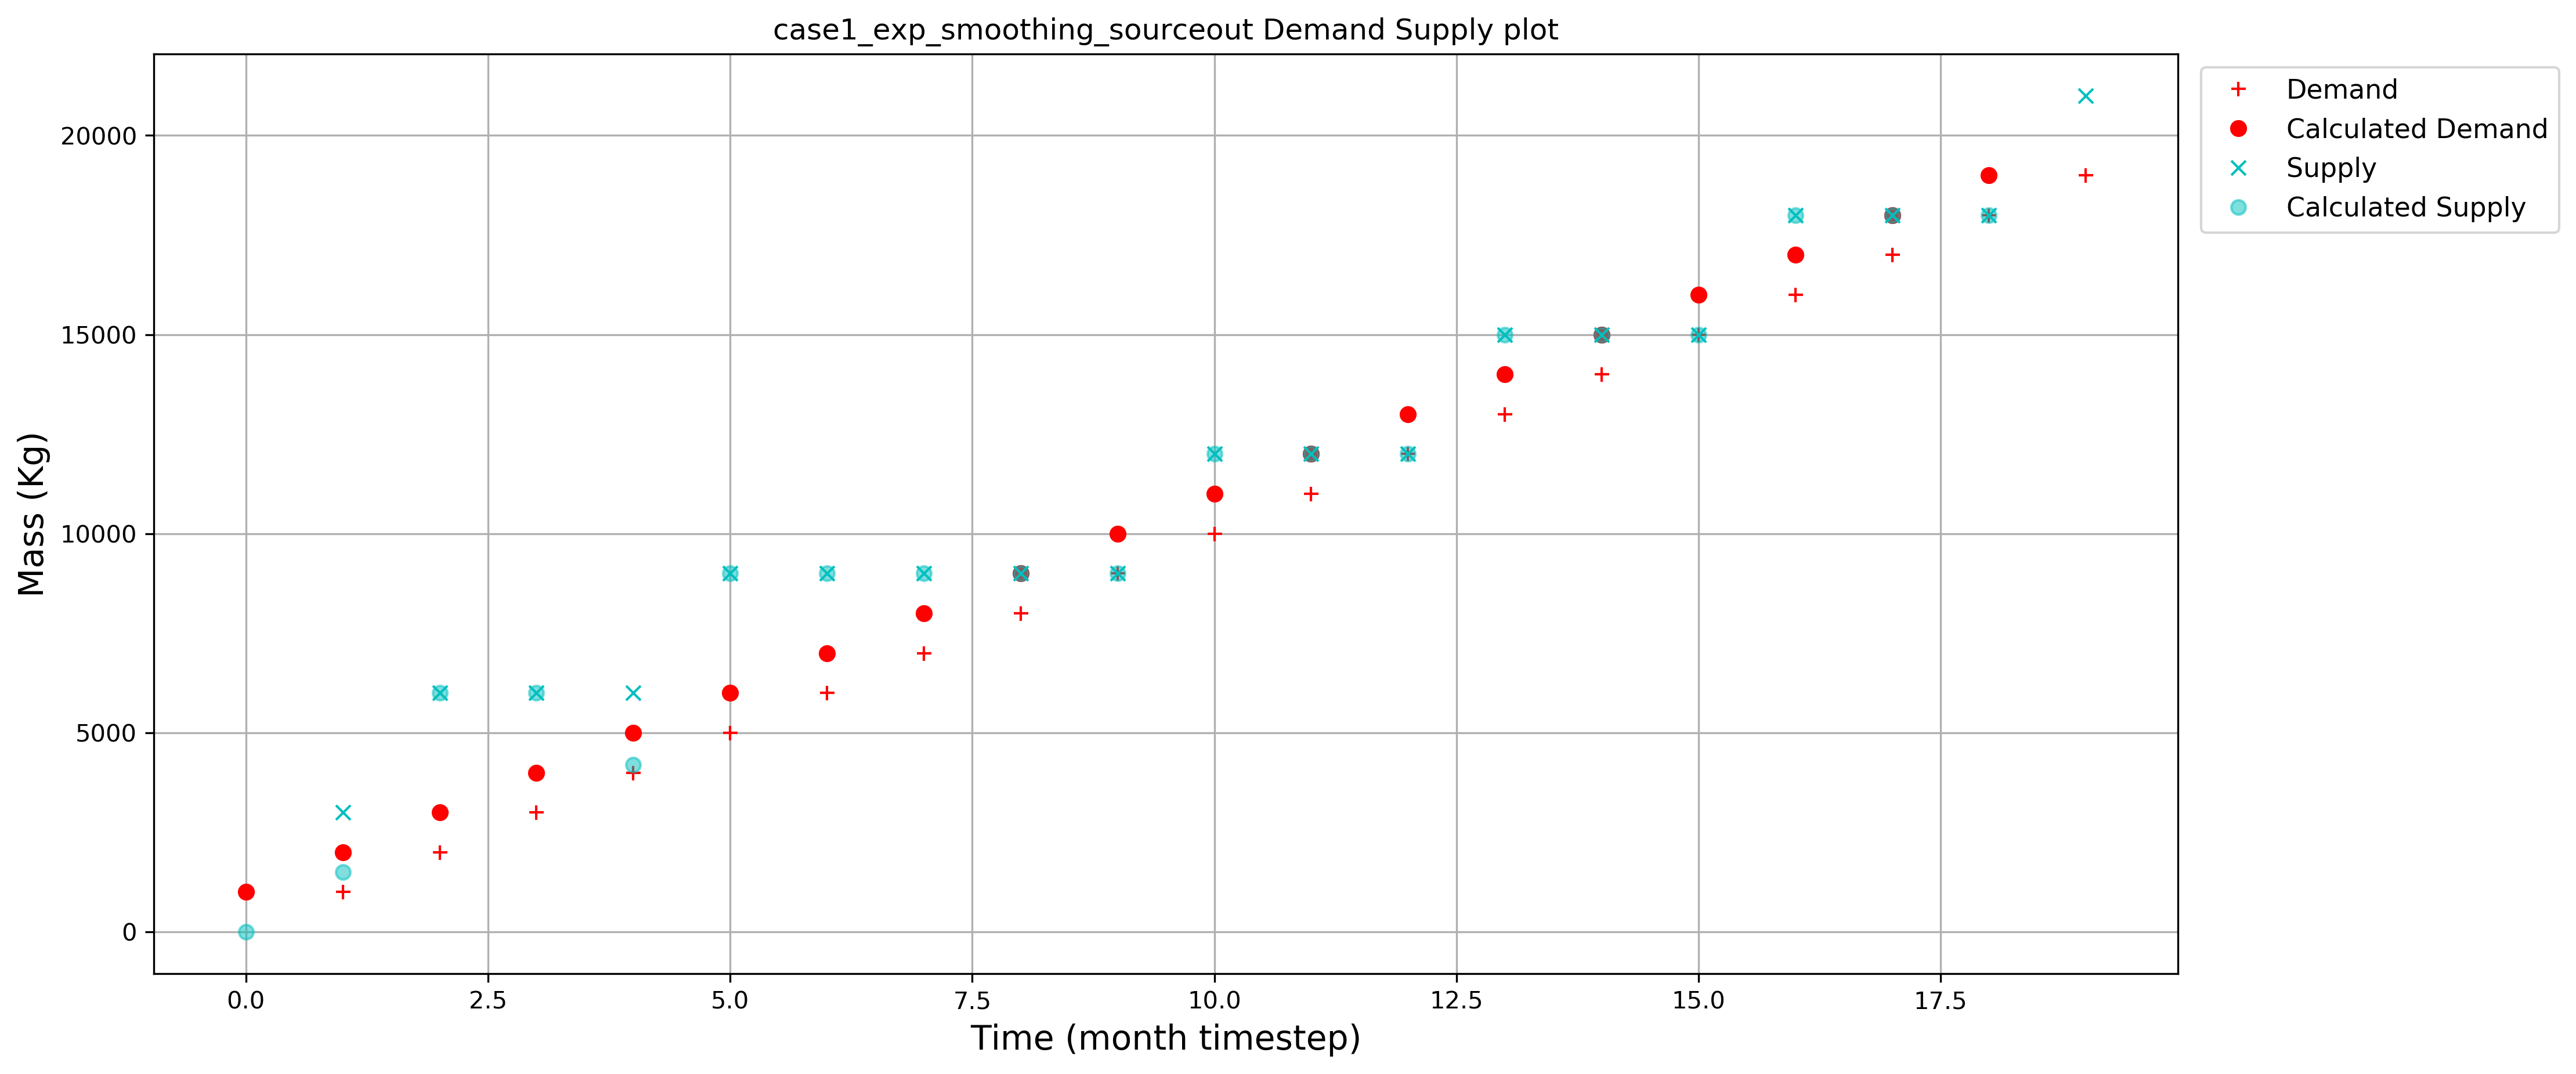

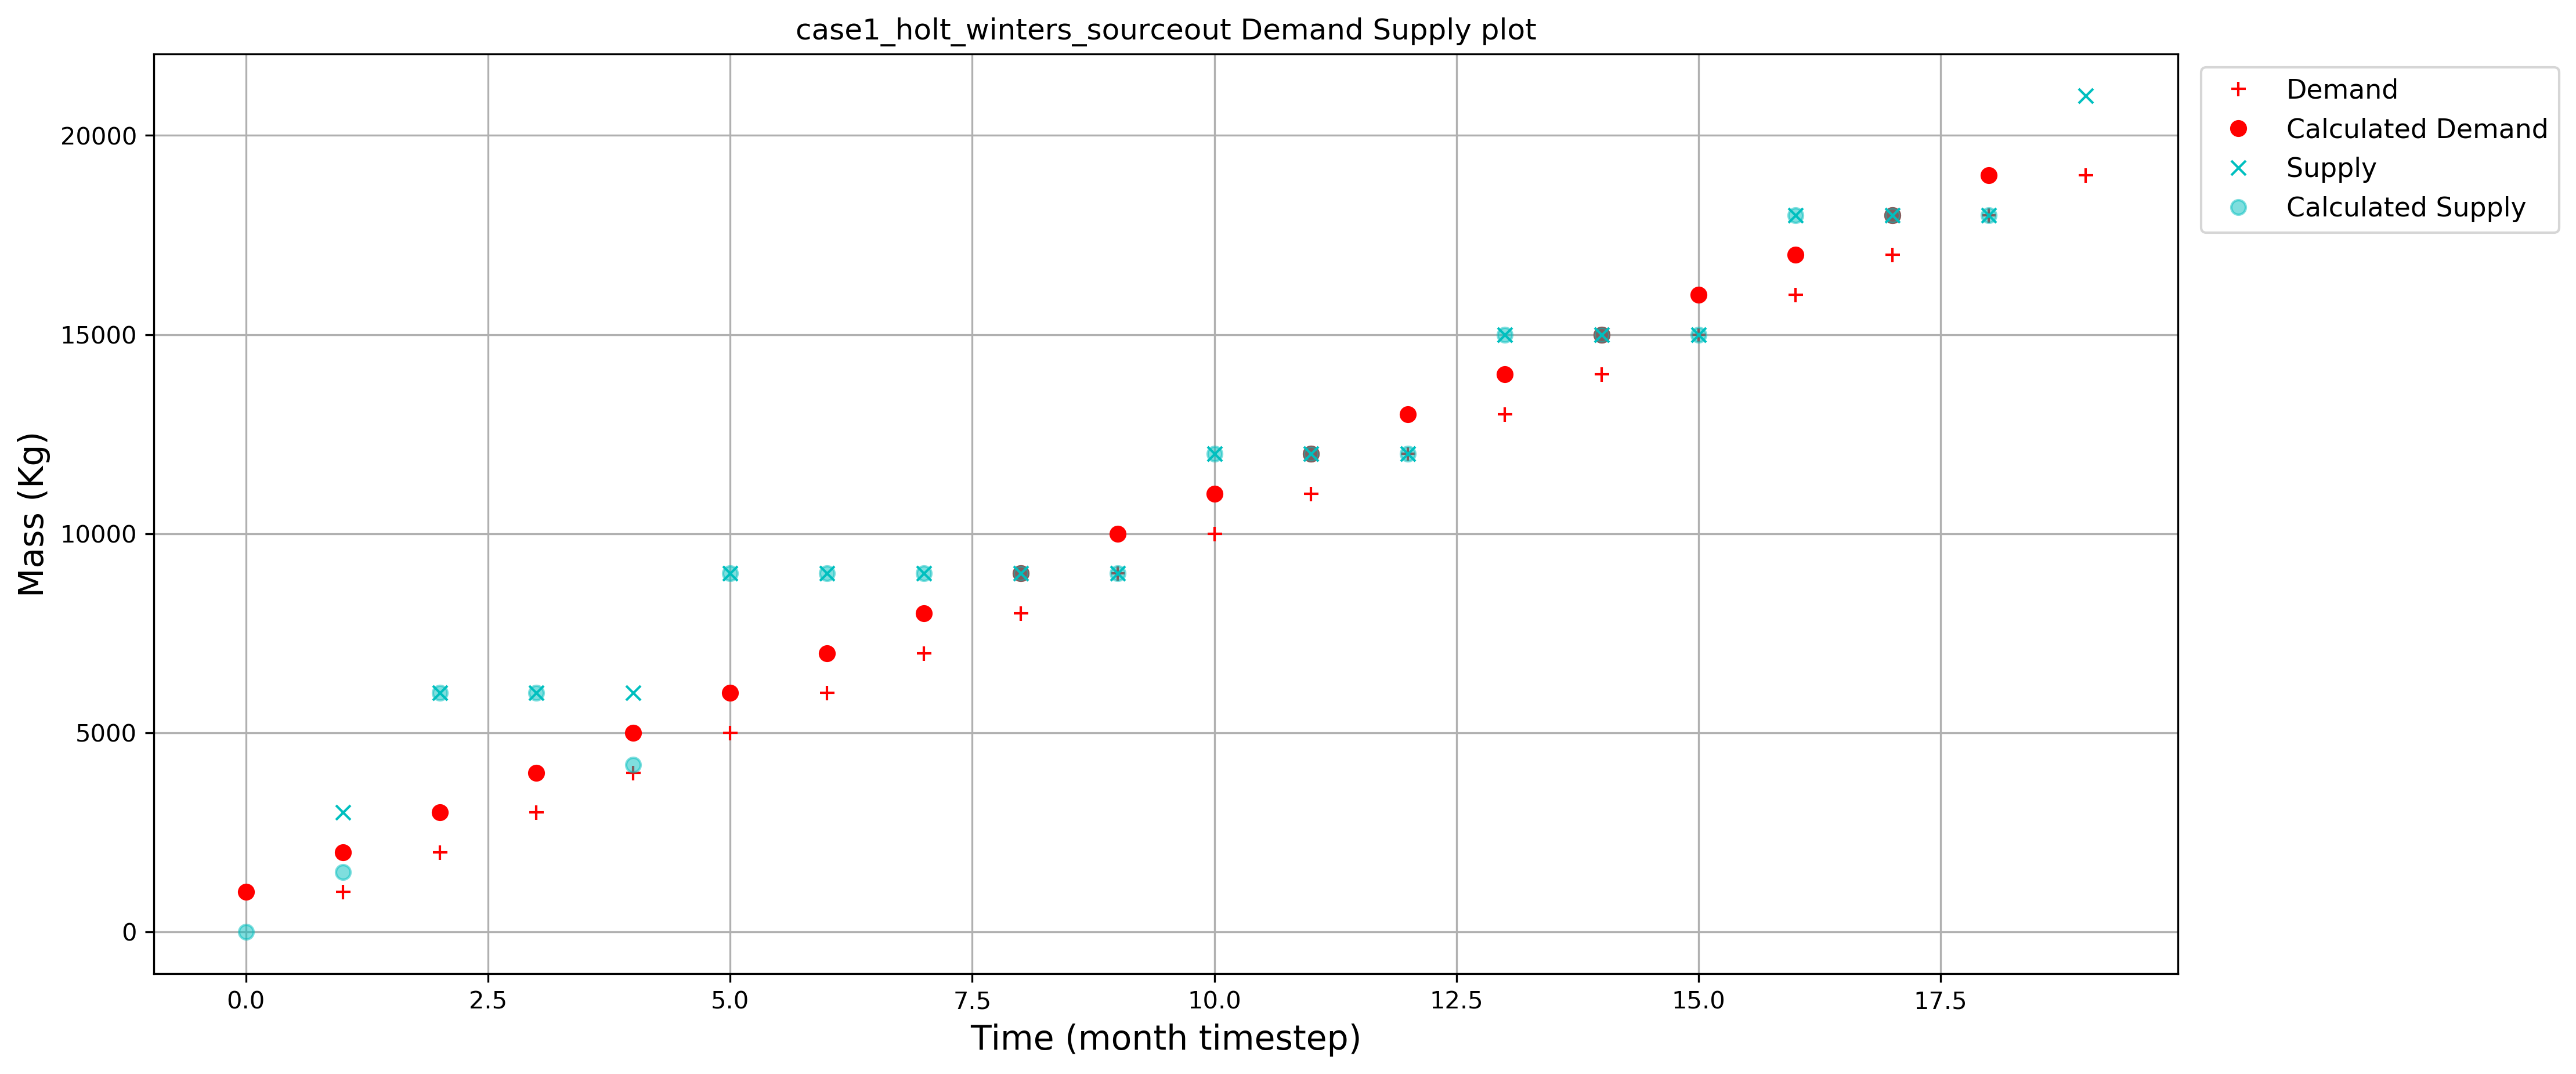

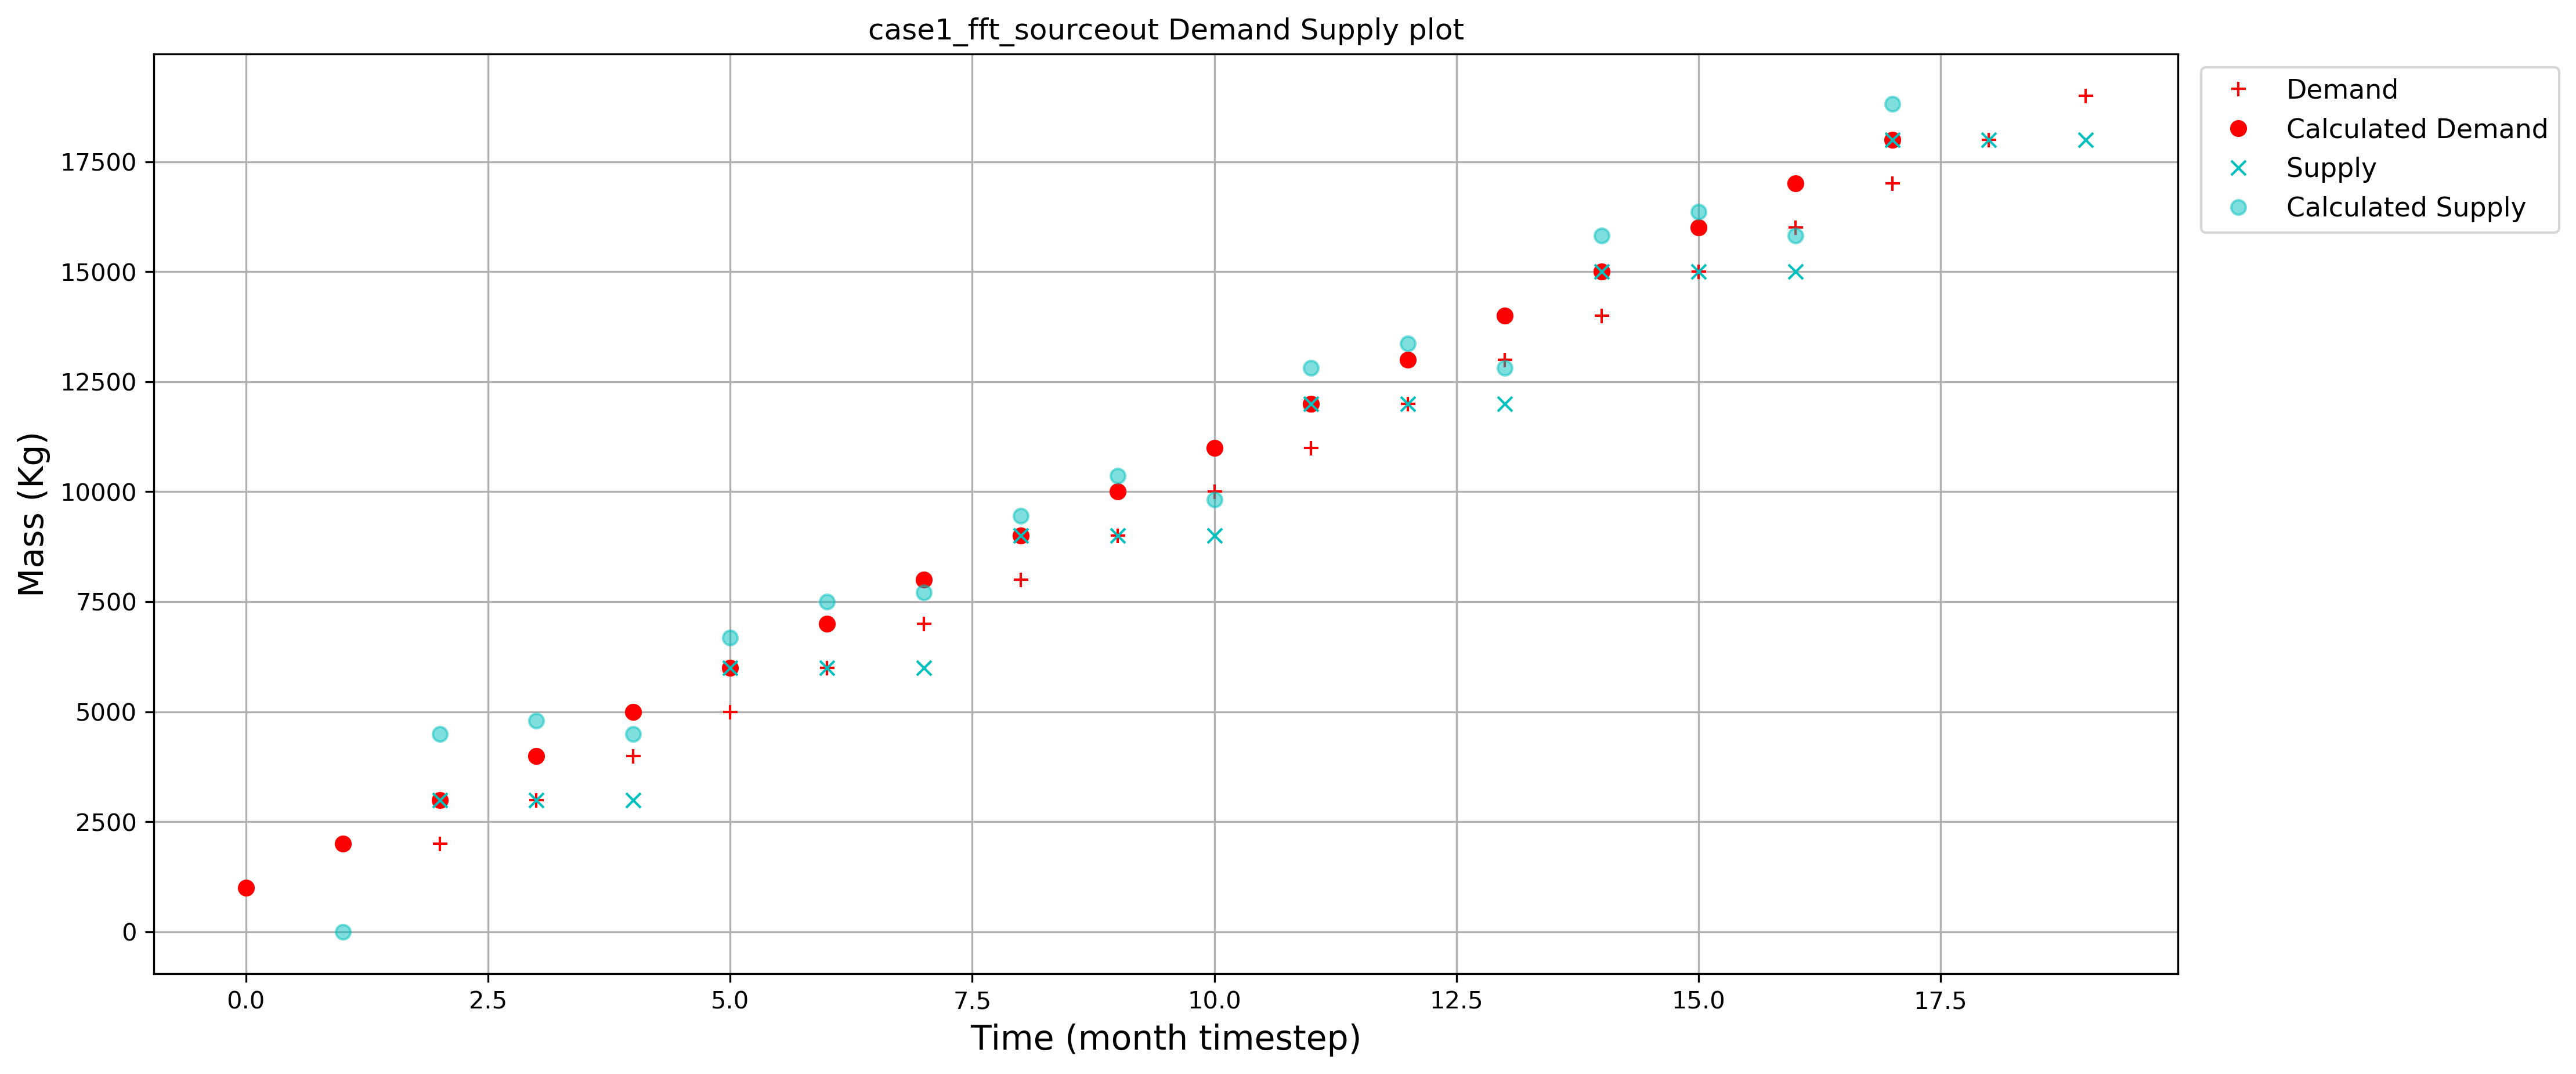

In [3]:
from IPython.display import Image
from IPython.display import display
#"ma", "arma", "arch", "poly", "exp_smoothing", "holt_winters", "fft"
I1 = Image(filename='case1_ma_sourceout.png')
I2 = Image(filename='case1_arma_sourceout.png')
I3 = Image(filename='case1_arch_sourceout.png')
I4 = Image(filename='case1_poly_sourceout.png')
I5 = Image(filename='case1_exp_smoothing_sourceout.png')
I6 = Image(filename='case1_holt_winters_sourceout.png')
I7 = Image(filename='case1_fft_sourceout.png')
display(I1,I2,I3,I4,I5,I6,I7)


In [4]:
df

,sourceout_residuals,sourceout_chi2,sourceout_undersupply
arch,0.819298,22635.808387,0
arma,0.819298,22635.808387,0
exp_smoothing,0.856140,22785.808387,0
fft,0.973382,1678.441412,5
holt_winters,0.856140,22785.808387,0
ma,0.940351,7785.808387,0
poly,0.945614,6947.144419,4
